In [1]:
from sqlalchemy import create_engine, text
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import geopandas as gpd
import folium
from folium.plugins import MarkerCluster
from folium.plugins import FastMarkerCluster
from sklearn.metrics.pairwise import haversine_distances
from math import radians, sin, cos, sqrt, atan2
from geopy.distance import geodesic
import fiona
from shapely.geometry import Point
from geopy.geocoders import Nominatim

In [2]:
all_uni_locations= pd.read_csv('../data/Colleges_and_Universities.csv')
all_uni_locations

,X,Y,OBJECTID,IPEDSID,NAME,ADDRESS,CITY,STATE,ZIP,ZIP4,...,ALIAS,SIZE_SET,INST_SIZE,PT_ENROLL,FT_ENROLL,TOT_ENROLL,HOUSING,DORM_CAP,TOT_EMP,SHELTER_ID
0,-8.209134e+06,4.953591e+06,1,190752,YESHIVA OF FAR ROCKAWAY DERECH AYSON RABBINICA...,802 HICKSVILLE RD,FAR ROCKAWAY,NY,11691,5219,...,NOT AVAILABLE,24,1,-999,43,43,1,35,15,NOT AVAILABLE
1,-8.267688e+06,4.940383e+06,2,481429,UNIVERSAL TRAINING INSTITUTE,174 JEFFERSON STREET,PERTH AMBOY,NJ,8861,4106,...,NOT AVAILABLE,-2,1,-999,176,176,2,-999,15,NOT AVAILABLE
2,-7.353945e+06,2.082890e+06,3,241739,UNIVERSIDAD ANA G. MENDEZ-CUPEY CAMPUS,1399 AVE. ANA G. MENDEZ,SAN JUAN,PR,926,2602,...,UAGM CUPEY,18,3,2780,6113,8893,2,-999,1020,NOT AVAILABLE
3,-1.006191e+07,4.664997e+06,4,455071,HEALING ARTS CENTER,"10073 MANCHESTER ROAD, SUITE 100",ST. LOUIS,MO,63122,NOT AVAILABLE,...,NOT AVAILABLE,-2,1,131,-999,131,2,-999,15,NOT AVAILABLE
4,-8.797220e+06,4.290711e+06,5,455141,AVEDA INSTITUTE-CHAPEL HILL,"201 S. ESTES DRIVE, SPACE 200 B",CHAPEL HILL,NC,27514,7001,...,NOT AVAILABLE,-2,1,-999,216,216,2,-999,25,NOT AVAILABLE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6554,-9.317151e+06,5.308190e+06,6555,494889,BAKER COLLEGE - FLINT,1050 WEST BRISTOL ROAD,FLINT,MI,48507,5508,...,NOT AVAILABLE,-2,-2,-999,-999,-999,-1,-999,-999,NOT AVAILABLE
6555,-1.082780e+07,4.536689e+06,6556,494898,WELLSPRING SCHOOL OF ALLIED HEALTH-WICHITA,"650 N CARRIAGE PARKWAY, STE 55",WICHITA,KS,67208,4501,...,NOT AVAILABLE,-2,1,-999,38,38,2,-999,14,NOT AVAILABLE
6556,-8.145887e+06,4.983035e+06,6557,494904,ACCESS CAREERS-ISLANDIA,"1930 VETERANS HIGHWAY, SUITE 10",ISLANDIA,NY,11749,1599,...,NOT AVAILABLE,-2,1,43,20,63,2,-999,18,NOT AVAILABLE
6557,-1.304572e+07,3.865065e+06,6558,494913,FRANCISCAN SCHOOL OF THEOLOGY - SAN DIEGO,5998 ALCALA PARK,SAN DIEGO,CA,92110,2492,...,NOT AVAILABLE,-2,-2,-999,-999,-999,-1,-999,-999,NOT AVAILABLE


In [3]:
crimes_incident= pd.read_csv('../data/crime/crimes_incident.csv')
crimes_incident

,unitid,institution_name,data_year_x,agency_id,incident_id,campus_agency,city_agency,county_agency,data_year_y,offense_id,offense_code,attempt_complete_flag,location_id,num_premises_entered,method_entry_code
0,101675,Miles College,2022,49,155372673,n,n,y,2022,185984862,520,C,25,NaN,NaN
1,101675,Miles College,2022,49,155372673,n,n,y,2022,185984863,35B,C,25,NaN,NaN
2,101675,Miles College,2022,49,155372673,n,n,y,2022,185984864,35A,C,25,NaN,NaN
3,101675,Miles College,2022,49,155377151,n,n,y,2022,185990229,13B,C,35,NaN,NaN
4,101675,Miles College,2022,49,166585891,n,n,y,2022,198846184,23D,C,35,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1785024,237215,Bluefield State University,2022,21572,164059491,n,y,n,2022,195960036,290,C,25,NaN,NaN
1785025,237215,Bluefield State University,2022,21572,164059208,n,y,n,2022,195959724,13B,C,35,NaN,NaN
1785026,237215,Bluefield State University,2022,21572,164059503,n,y,n,2022,195960050,13B,C,23,NaN,NaN
1785027,237215,Bluefield State University,2022,21572,164059238,n,y,n,2022,195959760,13B,C,35,NaN,NaN


In [4]:
crimes_merged=  pd.merge(crimes_incident, all_uni_locations, left_on=['unitid'], right_on=['IPEDSID'], how= 'inner')
crimes_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1785029 entries, 0 to 1785028
Data columns (total 60 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   unitid                 int64  
 1   institution_name       object 
 2   data_year_x            int64  
 3   agency_id              int64  
 4   incident_id            int64  
 5   campus_agency          object 
 6   city_agency            object 
 7   county_agency          object 
 8   data_year_y            int64  
 9   offense_id             int64  
 10  offense_code           object 
 11  attempt_complete_flag  object 
 12  location_id            int64  
 13  num_premises_entered   float64
 14  method_entry_code      object 
 15  X                      float64
 16  Y                      float64
 17  OBJECTID               int64  
 18  IPEDSID                int64  
 19  NAME                   object 
 20  ADDRESS                object 
 21  CITY                   object 
 22  STATE             

In [5]:
private_public = pd.read_csv('../data/school_data/public_private.csv')
private_public 

,Unnamed: 0,Institution,State,Designation,Designation.1
0,100654,Alabama A&M University,AL,1,4-year public
1,100724,Alabama State University,AL,1,4-year public
2,102030,Bishop State Community College,AL,2,2-year public
3,101240,Gadsden State Community College,AL,2,2-year public
4,102313,H. Councill Trenholm State Community\n College,AL,2,2-year public
...,...,...,...,...,...
96,234164,Virginia Union University,VA,3,4-year private
97,234137,Virginia University of Lynchburg,VA,3,4-year private
98,237215,Bluefield State College,WV,1,4-year public
99,237899,West Virginia State University,WV,1,4-year public


In [6]:
crimes_type_merged=  pd.merge(crimes_merged, private_public, left_on=['unitid'], right_on=['Unnamed: 0'], how= 'left')
crimes_type_merged.to_csv('../data/crime/crimes_type_merged.csv', index=False)
crimes_type_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1785029 entries, 0 to 1785028
Data columns (total 65 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   unitid                 int64  
 1   institution_name       object 
 2   data_year_x            int64  
 3   agency_id              int64  
 4   incident_id            int64  
 5   campus_agency          object 
 6   city_agency            object 
 7   county_agency          object 
 8   data_year_y            int64  
 9   offense_id             int64  
 10  offense_code           object 
 11  attempt_complete_flag  object 
 12  location_id            int64  
 13  num_premises_entered   float64
 14  method_entry_code      object 
 15  X                      float64
 16  Y                      float64
 17  OBJECTID               int64  
 18  IPEDSID                int64  
 19  NAME                   object 
 20  ADDRESS                object 
 21  CITY                   object 
 22  STATE             

In [7]:
crimes_type_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1785029 entries, 0 to 1785028
Data columns (total 65 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   unitid                 int64  
 1   institution_name       object 
 2   data_year_x            int64  
 3   agency_id              int64  
 4   incident_id            int64  
 5   campus_agency          object 
 6   city_agency            object 
 7   county_agency          object 
 8   data_year_y            int64  
 9   offense_id             int64  
 10  offense_code           object 
 11  attempt_complete_flag  object 
 12  location_id            int64  
 13  num_premises_entered   float64
 14  method_entry_code      object 
 15  X                      float64
 16  Y                      float64
 17  OBJECTID               int64  
 18  IPEDSID                int64  
 19  NAME                   object 
 20  ADDRESS                object 
 21  CITY                   object 
 22  STATE             

In [8]:
off_type= pd.read_csv('../data/crime/AR-2022/NIBRS_OFFENSE_TYPE.csv')
off_type

,offense_code,offense_name,crime_against,ct_flag,hc_flag,hc_code,offense_category_name,offense_group
0,09A,Murder and Nonnegligent Manslaughter,Person,f,t,01,Homicide Offenses,A
1,09B,Negligent Manslaughter,Person,f,t,,Homicide Offenses,A
2,09C,Justifiable Homicide,Person,f,f,,Homicide Offenses,A
3,11A,Rape,Person,f,t,02,Sex Offenses,A
4,11B,Sodomy,Person,f,t,02,Sex Offenses,A
...,...,...,...,...,...,...,...,...
81,90Z,All Other Offenses,Society,f,f,,All Other Offenses,B
82,90K,Failure to Appear,Society,f,f,,Other Offenses,B
83,90L,Federal Resource Violations,Society,f,f,,Other Offenses,B
84,90M,Perjury,Society,f,f,,Other Offenses,B


In [9]:
crimes_type_merged2=  pd.merge(crimes_type_merged, off_type, on=['offense_code'], how= 'left')

In [10]:
crimes_type_merged2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1785029 entries, 0 to 1785028
Data columns (total 72 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   unitid                 int64  
 1   institution_name       object 
 2   data_year_x            int64  
 3   agency_id              int64  
 4   incident_id            int64  
 5   campus_agency          object 
 6   city_agency            object 
 7   county_agency          object 
 8   data_year_y            int64  
 9   offense_id             int64  
 10  offense_code           object 
 11  attempt_complete_flag  object 
 12  location_id            int64  
 13  num_premises_entered   float64
 14  method_entry_code      object 
 15  X                      float64
 16  Y                      float64
 17  OBJECTID               int64  
 18  IPEDSID                int64  
 19  NAME                   object 
 20  ADDRESS                object 
 21  CITY                   object 
 22  STATE             

In [11]:
public_crime = crimes_type_merged2[(crimes_type_merged2.iloc[:, 63] == 1) | (crimes_type_merged2.iloc[:, 63] == 2)]
priv_crime = crimes_type_merged2[(crimes_type_merged2.iloc[:, 63] == 3) | (crimes_type_merged2.iloc[:, 63] == 4)]

In [12]:
filtered_columns = [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 32, 33, 21, 22, 23, 63, 64, 65, 66, 70] 
public_crimes= public_crime.iloc[:, filtered_columns]
public_crimes=public_crimes.sort_values(by=['STATE','institution_name'])
public_crimes.reset_index(drop=True, inplace=True)
public_crimes

,unitid,institution_name,agency_id,incident_id,campus_agency,city_agency,county_agency,data_year_y,offense_id,offense_code,LATITUDE,LONGITUDE,CITY,STATE,ZIP,Designation,Designation.1,offense_name,crime_against,offense_category_name
0,100654,Alabama A & M University,360,159609783,y,n,n,2022,190851138,290,34.783368,-86.568502,NORMAL,AL,35762,1,4-year public,Destruction/Damage/Vandalism of Property,Property,Destruction/Damage/Vandalism of Property
1,100654,Alabama A & M University,360,148659447,y,n,n,2022,178273058,290,34.783368,-86.568502,NORMAL,AL,35762,1,4-year public,Destruction/Damage/Vandalism of Property,Property,Destruction/Damage/Vandalism of Property
2,100654,Alabama A & M University,360,159058356,y,n,n,2022,190212660,23H,34.783368,-86.568502,NORMAL,AL,35762,1,4-year public,All Other Larceny,Property,Larceny/Theft Offenses
3,100654,Alabama A & M University,360,162503810,y,n,n,2022,194180644,13B,34.783368,-86.568502,NORMAL,AL,35762,1,4-year public,Simple Assault,Person,Assault Offenses
4,100654,Alabama A & M University,360,166594835,y,n,n,2022,198856719,23D,34.783368,-86.568502,NORMAL,AL,35762,1,4-year public,Theft From Building,Property,Larceny/Theft Offenses
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
681785,237899,West Virginia State University,21494,150440041,y,n,n,2022,180329910,23D,38.379002,-81.768020,INSTITUTE,WV,25112,1,4-year public,Theft From Building,Property,Larceny/Theft Offenses
681786,237899,West Virginia State University,21494,150440057,y,n,n,2022,180329929,13A,38.379002,-81.768020,INSTITUTE,WV,25112,1,4-year public,Aggravated Assault,Person,Assault Offenses
681787,237899,West Virginia State University,21494,159595021,y,n,n,2022,190834048,35A,38.379002,-81.768020,INSTITUTE,WV,25112,1,4-year public,Drug/Narcotic Violations,Society,Drug/Narcotic Offenses
681788,237899,West Virginia State University,21494,159595036,y,n,n,2022,190834061,11D,38.379002,-81.768020,INSTITUTE,WV,25112,1,4-year public,Fondling,Person,Sex Offenses


In [13]:
priv_crimes= priv_crime.iloc[:, filtered_columns]
priv_crimes=priv_crimes.sort_values(by=['STATE','institution_name'])
priv_crimes.reset_index(drop=True, inplace=True)
priv_crimes

,unitid,institution_name,agency_id,incident_id,campus_agency,city_agency,county_agency,data_year_y,offense_id,offense_code,LATITUDE,LONGITUDE,CITY,STATE,ZIP,Designation,Designation.1,offense_name,crime_against,offense_category_name
0,101675,Miles College,49,155372673,n,n,y,2022,185984862,520,33.481170,-86.908191,FAIRFIELD,AL,35064,3,4-year private,Weapon Law Violations,Society,Weapon Law Violations
1,101675,Miles College,49,155372673,n,n,y,2022,185984863,35B,33.481170,-86.908191,FAIRFIELD,AL,35064,3,4-year private,Drug Equipment Violations,Society,Drug/Narcotic Offenses
2,101675,Miles College,49,155372673,n,n,y,2022,185984864,35A,33.481170,-86.908191,FAIRFIELD,AL,35064,3,4-year private,Drug/Narcotic Violations,Society,Drug/Narcotic Offenses
3,101675,Miles College,49,155377151,n,n,y,2022,185990229,13B,33.481170,-86.908191,FAIRFIELD,AL,35064,3,4-year private,Simple Assault,Person,Assault Offenses
4,101675,Miles College,49,166585891,n,n,y,2022,198846184,23D,33.481170,-86.908191,FAIRFIELD,AL,35064,3,4-year private,Theft From Building,Property,Larceny/Theft Offenses
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1103234,234137,Virginia University of Lynchburg,20437,170268408,n,y,n,2022,203093022,26A,37.395135,-79.151518,LYNCHBURG,VA,24501,3,4-year private,False Pretenses/Swindle/Confidence Game,Property,Fraud Offenses
1103235,234137,Virginia University of Lynchburg,20437,170268106,n,y,n,2022,203092681,290,37.395135,-79.151518,LYNCHBURG,VA,24501,3,4-year private,Destruction/Damage/Vandalism of Property,Property,Destruction/Damage/Vandalism of Property
1103236,234137,Virginia University of Lynchburg,20437,170268105,n,y,n,2022,203092680,26A,37.395135,-79.151518,LYNCHBURG,VA,24501,3,4-year private,False Pretenses/Swindle/Confidence Game,Property,Fraud Offenses
1103237,234137,Virginia University of Lynchburg,20437,170268120,n,y,n,2022,203092696,11D,37.395135,-79.151518,LYNCHBURG,VA,24501,3,4-year private,Fondling,Person,Sex Offenses


In [14]:
on_camp_pub=public_crimes[public_crimes.iloc[:, 4] == 'y']
on_camp_pub['unitid'].nunique()

21

In [15]:
on_camp_priv=priv_crimes[priv_crimes.iloc[:, 4] == 'y']
on_camp_priv['unitid'].nunique()

6

In [16]:
on_camp_priv

,unitid,institution_name,agency_id,incident_id,campus_agency,city_agency,county_agency,data_year_y,offense_id,offense_code,LATITUDE,LONGITUDE,CITY,STATE,ZIP,Designation,Designation.1,offense_name,crime_against,offense_category_name
29887,102377,Tuskegee University,23115,155343201,y,n,n,2022,185950233,23H,32.431021,-85.710315,TUSKEGEE,AL,36088,3,4-year private,All Other Larceny,Property,Larceny/Theft Offenses
29888,102377,Tuskegee University,23115,162490927,y,n,n,2022,194165407,23H,32.431021,-85.710315,TUSKEGEE,AL,36088,3,4-year private,All Other Larceny,Property,Larceny/Theft Offenses
29889,102377,Tuskegee University,23115,162490905,y,n,n,2022,194165383,13B,32.431021,-85.710315,TUSKEGEE,AL,36088,3,4-year private,Simple Assault,Person,Assault Offenses
29890,102377,Tuskegee University,23115,162490914,y,n,n,2022,194165394,11A,32.431021,-85.710315,TUSKEGEE,AL,36088,3,4-year private,Rape,Person,Sex Offenses
29891,102377,Tuskegee University,23115,166569343,y,n,n,2022,198826645,520,32.431021,-85.710315,TUSKEGEE,AL,36088,3,4-year private,Weapon Law Violations,Society,Weapon Law Violations
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1081226,232265,Hampton University,20431,164869974,y,n,n,2022,196883176,13B,37.021502,-76.331933,HAMPTON,VA,23668,3,4-year private,Simple Assault,Person,Assault Offenses
1081227,232265,Hampton University,20431,164869987,y,n,n,2022,196883192,290,37.021502,-76.331933,HAMPTON,VA,23668,3,4-year private,Destruction/Damage/Vandalism of Property,Property,Destruction/Damage/Vandalism of Property
1081228,232265,Hampton University,20431,170256762,y,n,n,2022,203079387,23D,37.021502,-76.331933,HAMPTON,VA,23668,3,4-year private,Theft From Building,Property,Larceny/Theft Offenses
1081229,232265,Hampton University,20431,168531739,y,n,n,2022,201084887,290,37.021502,-76.331933,HAMPTON,VA,23668,3,4-year private,Destruction/Damage/Vandalism of Property,Property,Destruction/Damage/Vandalism of Property


In [17]:
on_camp_pub

,unitid,institution_name,agency_id,incident_id,campus_agency,city_agency,county_agency,data_year_y,offense_id,offense_code,LATITUDE,LONGITUDE,CITY,STATE,ZIP,Designation,Designation.1,offense_name,crime_against,offense_category_name
0,100654,Alabama A & M University,360,159609783,y,n,n,2022,190851138,290,34.783368,-86.568502,NORMAL,AL,35762,1,4-year public,Destruction/Damage/Vandalism of Property,Property,Destruction/Damage/Vandalism of Property
1,100654,Alabama A & M University,360,148659447,y,n,n,2022,178273058,290,34.783368,-86.568502,NORMAL,AL,35762,1,4-year public,Destruction/Damage/Vandalism of Property,Property,Destruction/Damage/Vandalism of Property
2,100654,Alabama A & M University,360,159058356,y,n,n,2022,190212660,23H,34.783368,-86.568502,NORMAL,AL,35762,1,4-year public,All Other Larceny,Property,Larceny/Theft Offenses
3,100654,Alabama A & M University,360,162503810,y,n,n,2022,194180644,13B,34.783368,-86.568502,NORMAL,AL,35762,1,4-year public,Simple Assault,Person,Assault Offenses
4,100654,Alabama A & M University,360,166594835,y,n,n,2022,198856719,23D,34.783368,-86.568502,NORMAL,AL,35762,1,4-year public,Theft From Building,Property,Larceny/Theft Offenses
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
681785,237899,West Virginia State University,21494,150440041,y,n,n,2022,180329910,23D,38.379002,-81.768020,INSTITUTE,WV,25112,1,4-year public,Theft From Building,Property,Larceny/Theft Offenses
681786,237899,West Virginia State University,21494,150440057,y,n,n,2022,180329929,13A,38.379002,-81.768020,INSTITUTE,WV,25112,1,4-year public,Aggravated Assault,Person,Assault Offenses
681787,237899,West Virginia State University,21494,159595021,y,n,n,2022,190834048,35A,38.379002,-81.768020,INSTITUTE,WV,25112,1,4-year public,Drug/Narcotic Violations,Society,Drug/Narcotic Offenses
681788,237899,West Virginia State University,21494,159595036,y,n,n,2022,190834061,11D,38.379002,-81.768020,INSTITUTE,WV,25112,1,4-year public,Fondling,Person,Sex Offenses


In [18]:
on_camp_pub.info()

<class 'pandas.core.frame.DataFrame'>
Index: 26051 entries, 0 to 681789
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   unitid                 26051 non-null  int64  
 1   institution_name       26051 non-null  object 
 2   agency_id              26051 non-null  int64  
 3   incident_id            26051 non-null  int64  
 4   campus_agency          26051 non-null  object 
 5   city_agency            26051 non-null  object 
 6   county_agency          26051 non-null  object 
 7   data_year_y            26051 non-null  int64  
 8   offense_id             26051 non-null  int64  
 9   offense_code           26051 non-null  object 
 10  LATITUDE               26051 non-null  float64
 11  LONGITUDE              26051 non-null  float64
 12  CITY                   26051 non-null  object 
 13  STATE                  26051 non-null  object 
 14  ZIP                    26051 non-null  int64  
 15  Design

In [19]:
on_camp_pub['offense_code_count_by_school'] = on_camp_pub.groupby(['institution_name','offense_code'])['offense_id'].transform('count')
on_camp_pub['offense_count_by_school'] = on_camp_pub.groupby('institution_name')['offense_id'].transform('count')
on_camp_pub.sort_values(by=['STATE','institution_name','offense_code_count_by_school','offense_count_by_school'], ascending=[True, True, False, False])

C:\Users\joyce\AppData\Local\Temp\ipykernel_33276\3508254925.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  on_camp_pub['offense_code_count_by_school'] = on_camp_pub.groupby(['institution_name','offense_code'])['offense_id'].transform('count')
C:\Users\joyce\AppData\Local\Temp\ipykernel_33276\3508254925.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  on_camp_pub['offense_count_by_school'] = on_camp_pub.groupby('institution_name')['offense_id'].transform('count')


,unitid,institution_name,agency_id,incident_id,campus_agency,city_agency,county_agency,data_year_y,offense_id,offense_code,...,CITY,STATE,ZIP,Designation,Designation.1,offense_name,crime_against,offense_category_name,offense_code_count_by_school,offense_count_by_school
0,100654,Alabama A & M University,360,159609783,y,n,n,2022,190851138,290,...,NORMAL,AL,35762,1,4-year public,Destruction/Damage/Vandalism of Property,Property,Destruction/Damage/Vandalism of Property,15,86
1,100654,Alabama A & M University,360,148659447,y,n,n,2022,178273058,290,...,NORMAL,AL,35762,1,4-year public,Destruction/Damage/Vandalism of Property,Property,Destruction/Damage/Vandalism of Property,15,86
6,100654,Alabama A & M University,360,159058421,y,n,n,2022,190212749,290,...,NORMAL,AL,35762,1,4-year public,Destruction/Damage/Vandalism of Property,Property,Destruction/Damage/Vandalism of Property,15,86
22,100654,Alabama A & M University,360,162503860,y,n,n,2022,194180703,290,...,NORMAL,AL,35762,1,4-year public,Destruction/Damage/Vandalism of Property,Property,Destruction/Damage/Vandalism of Property,15,86
24,100654,Alabama A & M University,360,162503856,y,n,n,2022,194180699,290,...,NORMAL,AL,35762,1,4-year public,Destruction/Damage/Vandalism of Property,Property,Destruction/Damage/Vandalism of Property,15,86
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
681787,237899,West Virginia State University,21494,159595021,y,n,n,2022,190834048,35A,...,INSTITUTE,WV,25112,1,4-year public,Drug/Narcotic Violations,Society,Drug/Narcotic Offenses,2,5
681789,237899,West Virginia State University,21494,161356818,y,n,n,2022,192865193,35A,...,INSTITUTE,WV,25112,1,4-year public,Drug/Narcotic Violations,Society,Drug/Narcotic Offenses,2,5
681785,237899,West Virginia State University,21494,150440041,y,n,n,2022,180329910,23D,...,INSTITUTE,WV,25112,1,4-year public,Theft From Building,Property,Larceny/Theft Offenses,1,5
681786,237899,West Virginia State University,21494,150440057,y,n,n,2022,180329929,13A,...,INSTITUTE,WV,25112,1,4-year public,Aggravated Assault,Person,Assault Offenses,1,5


In [20]:
on_camp_priv['offense_code_count_by_school'] = on_camp_priv.groupby(['institution_name','offense_code'])['offense_id'].transform('count')
on_camp_priv['offense_count_by_school'] = on_camp_priv.groupby('institution_name')['offense_id'].transform('count')
on_camp_priv.sort_values(by=['STATE','institution_name','offense_code_count_by_school','offense_count_by_school'], ascending=[True, True, False, False])
on_camp_priv

C:\Users\joyce\AppData\Local\Temp\ipykernel_33276\415066920.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  on_camp_priv['offense_code_count_by_school'] = on_camp_priv.groupby(['institution_name','offense_code'])['offense_id'].transform('count')
C:\Users\joyce\AppData\Local\Temp\ipykernel_33276\415066920.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  on_camp_priv['offense_count_by_school'] = on_camp_priv.groupby('institution_name')['offense_id'].transform('count')


,unitid,institution_name,agency_id,incident_id,campus_agency,city_agency,county_agency,data_year_y,offense_id,offense_code,...,CITY,STATE,ZIP,Designation,Designation.1,offense_name,crime_against,offense_category_name,offense_code_count_by_school,offense_count_by_school
29887,102377,Tuskegee University,23115,155343201,y,n,n,2022,185950233,23H,...,TUSKEGEE,AL,36088,3,4-year private,All Other Larceny,Property,Larceny/Theft Offenses,2,6
29888,102377,Tuskegee University,23115,162490927,y,n,n,2022,194165407,23H,...,TUSKEGEE,AL,36088,3,4-year private,All Other Larceny,Property,Larceny/Theft Offenses,2,6
29889,102377,Tuskegee University,23115,162490905,y,n,n,2022,194165383,13B,...,TUSKEGEE,AL,36088,3,4-year private,Simple Assault,Person,Assault Offenses,1,6
29890,102377,Tuskegee University,23115,162490914,y,n,n,2022,194165394,11A,...,TUSKEGEE,AL,36088,3,4-year private,Rape,Person,Sex Offenses,1,6
29891,102377,Tuskegee University,23115,166569343,y,n,n,2022,198826645,520,...,TUSKEGEE,AL,36088,3,4-year private,Weapon Law Violations,Society,Weapon Law Violations,1,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1081226,232265,Hampton University,20431,164869974,y,n,n,2022,196883176,13B,...,HAMPTON,VA,23668,3,4-year private,Simple Assault,Person,Assault Offenses,6,94
1081227,232265,Hampton University,20431,164869987,y,n,n,2022,196883192,290,...,HAMPTON,VA,23668,3,4-year private,Destruction/Damage/Vandalism of Property,Property,Destruction/Damage/Vandalism of Property,44,94
1081228,232265,Hampton University,20431,170256762,y,n,n,2022,203079387,23D,...,HAMPTON,VA,23668,3,4-year private,Theft From Building,Property,Larceny/Theft Offenses,14,94
1081229,232265,Hampton University,20431,168531739,y,n,n,2022,201084887,290,...,HAMPTON,VA,23668,3,4-year private,Destruction/Damage/Vandalism of Property,Property,Destruction/Damage/Vandalism of Property,44,94


In [21]:
cat_df=pd.concat([on_camp_pub, on_camp_priv], axis=0)
cat_df

,unitid,institution_name,agency_id,incident_id,campus_agency,city_agency,county_agency,data_year_y,offense_id,offense_code,...,CITY,STATE,ZIP,Designation,Designation.1,offense_name,crime_against,offense_category_name,offense_code_count_by_school,offense_count_by_school
0,100654,Alabama A & M University,360,159609783,y,n,n,2022,190851138,290,...,NORMAL,AL,35762,1,4-year public,Destruction/Damage/Vandalism of Property,Property,Destruction/Damage/Vandalism of Property,15,86
1,100654,Alabama A & M University,360,148659447,y,n,n,2022,178273058,290,...,NORMAL,AL,35762,1,4-year public,Destruction/Damage/Vandalism of Property,Property,Destruction/Damage/Vandalism of Property,15,86
2,100654,Alabama A & M University,360,159058356,y,n,n,2022,190212660,23H,...,NORMAL,AL,35762,1,4-year public,All Other Larceny,Property,Larceny/Theft Offenses,8,86
3,100654,Alabama A & M University,360,162503810,y,n,n,2022,194180644,13B,...,NORMAL,AL,35762,1,4-year public,Simple Assault,Person,Assault Offenses,14,86
4,100654,Alabama A & M University,360,166594835,y,n,n,2022,198856719,23D,...,NORMAL,AL,35762,1,4-year public,Theft From Building,Property,Larceny/Theft Offenses,4,86
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1081226,232265,Hampton University,20431,164869974,y,n,n,2022,196883176,13B,...,HAMPTON,VA,23668,3,4-year private,Simple Assault,Person,Assault Offenses,6,94
1081227,232265,Hampton University,20431,164869987,y,n,n,2022,196883192,290,...,HAMPTON,VA,23668,3,4-year private,Destruction/Damage/Vandalism of Property,Property,Destruction/Damage/Vandalism of Property,44,94
1081228,232265,Hampton University,20431,170256762,y,n,n,2022,203079387,23D,...,HAMPTON,VA,23668,3,4-year private,Theft From Building,Property,Larceny/Theft Offenses,14,94
1081229,232265,Hampton University,20431,168531739,y,n,n,2022,201084887,290,...,HAMPTON,VA,23668,3,4-year private,Destruction/Damage/Vandalism of Property,Property,Destruction/Damage/Vandalism of Property,44,94


In [22]:
enrollment = pd.read_csv('../data/school_data/enroll_degree_count.csv')
enrollment 

,UnitID,Institution Name,Number of students receiving a Doctor's degree (DRVC2022),Number of students receiving a Master's degree (DRVC2022),Number of students receiving a Bachelor's degree (DRVC2022),Number of students receiving an Associate's degree (DRVC2022),Undergraduate enrollment (DRVEF2021_RV),Full-time undergraduate enrollment (DRVEF2021_RV),Total enrollment (DRVEF2021_RV),Full-time enrollment (DRVEF2021_RV),Institution size category (HD2021),Unnamed: 11
0,100654,Alabama A & M University,9.0,249.0,511.0,0,5107,4529,5969,5064,3,NaN
1,100724,Alabama State University,24.0,119.0,480.0,0,3499,3055,3964,3378,2,NaN
2,138716,Albany State University,0.0,148.0,580.0,698,5824,3880,6297,4140,3,NaN
3,175342,Alcorn State University,7.0,145.0,608.0,23,2533,2131,3074,2302,2,NaN
4,217624,Allen University,0.0,14.0,62.0,0,563,544,621,578,1,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
96,237899,West Virginia State University,0.0,66.0,334.0,0,3281,1317,3415,1392,2,NaN
97,206491,Wilberforce University,0.0,5.0,68.0,0,544,381,557,389,1,NaN
98,229887,Wiley College,0.0,0.0,107.0,7,665,584,665,584,1,NaN
99,199999,Winston-Salem State University,59.0,132.0,930.0,0,4726,3961,5226,4322,3,NaN


In [23]:
total_enrollment = enrollment.iloc[:, [0, 1, 8]]
total_enrollment

,UnitID,Institution Name,Total enrollment (DRVEF2021_RV)
0,100654,Alabama A & M University,5969
1,100724,Alabama State University,3964
2,138716,Albany State University,6297
3,175342,Alcorn State University,3074
4,217624,Allen University,621
...,...,...,...
96,237899,West Virginia State University,3415
97,206491,Wilberforce University,557
98,229887,Wiley College,665
99,199999,Winston-Salem State University,5226


In [24]:
total_enrollment.rename(columns={total_enrollment.columns[2]: "total_enrollment"}, inplace=True)
total_enrollment.rename(columns={total_enrollment.columns[1]: "institution_name"}, inplace=True)
total_enrollment

C:\Users\joyce\AppData\Local\Temp\ipykernel_33276\3082260818.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_enrollment.rename(columns={total_enrollment.columns[2]: "total_enrollment"}, inplace=True)
C:\Users\joyce\AppData\Local\Temp\ipykernel_33276\3082260818.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_enrollment.rename(columns={total_enrollment.columns[1]: "institution_name"}, inplace=True)


,UnitID,institution_name,total_enrollment
0,100654,Alabama A & M University,5969
1,100724,Alabama State University,3964
2,138716,Albany State University,6297
3,175342,Alcorn State University,3074
4,217624,Allen University,621
...,...,...,...
96,237899,West Virginia State University,3415
97,206491,Wilberforce University,557
98,229887,Wiley College,665
99,199999,Winston-Salem State University,5226


In [25]:
crimes_enrollment=  pd.merge(cat_df, total_enrollment, left_on=['unitid'], right_on=['UnitID'], how= 'left')
crimes_enrollment.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26310 entries, 0 to 26309
Data columns (total 25 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   unitid                        26310 non-null  int64  
 1   institution_name_x            26310 non-null  object 
 2   agency_id                     26310 non-null  int64  
 3   incident_id                   26310 non-null  int64  
 4   campus_agency                 26310 non-null  object 
 5   city_agency                   26310 non-null  object 
 6   county_agency                 26310 non-null  object 
 7   data_year_y                   26310 non-null  int64  
 8   offense_id                    26310 non-null  int64  
 9   offense_code                  26310 non-null  object 
 10  LATITUDE                      26310 non-null  float64
 11  LONGITUDE                     26310 non-null  float64
 12  CITY                          26310 non-null  object 
 13  S

In [26]:
dropping= [22, 23]
crimes_enrollment.drop(crimes_enrollment.columns[dropping], axis=1, inplace=True)
crimes_enrollment

,unitid,institution_name_x,agency_id,incident_id,campus_agency,city_agency,county_agency,data_year_y,offense_id,offense_code,...,STATE,ZIP,Designation,Designation.1,offense_name,crime_against,offense_category_name,offense_code_count_by_school,offense_count_by_school,total_enrollment
0,100654,Alabama A & M University,360,159609783,y,n,n,2022,190851138,290,...,AL,35762,1,4-year public,Destruction/Damage/Vandalism of Property,Property,Destruction/Damage/Vandalism of Property,15,86,5969
1,100654,Alabama A & M University,360,148659447,y,n,n,2022,178273058,290,...,AL,35762,1,4-year public,Destruction/Damage/Vandalism of Property,Property,Destruction/Damage/Vandalism of Property,15,86,5969
2,100654,Alabama A & M University,360,159058356,y,n,n,2022,190212660,23H,...,AL,35762,1,4-year public,All Other Larceny,Property,Larceny/Theft Offenses,8,86,5969
3,100654,Alabama A & M University,360,162503810,y,n,n,2022,194180644,13B,...,AL,35762,1,4-year public,Simple Assault,Person,Assault Offenses,14,86,5969
4,100654,Alabama A & M University,360,166594835,y,n,n,2022,198856719,23D,...,AL,35762,1,4-year public,Theft From Building,Property,Larceny/Theft Offenses,4,86,5969
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26305,232265,Hampton University,20431,164869974,y,n,n,2022,196883176,13B,...,VA,23668,3,4-year private,Simple Assault,Person,Assault Offenses,6,94,3317
26306,232265,Hampton University,20431,164869987,y,n,n,2022,196883192,290,...,VA,23668,3,4-year private,Destruction/Damage/Vandalism of Property,Property,Destruction/Damage/Vandalism of Property,44,94,3317
26307,232265,Hampton University,20431,170256762,y,n,n,2022,203079387,23D,...,VA,23668,3,4-year private,Theft From Building,Property,Larceny/Theft Offenses,14,94,3317
26308,232265,Hampton University,20431,168531739,y,n,n,2022,201084887,290,...,VA,23668,3,4-year private,Destruction/Damage/Vandalism of Property,Property,Destruction/Damage/Vandalism of Property,44,94,3317


In [27]:
aid_by_school= pd.read_csv('../data/school_data/aid_by_school.csv')
aid_by_school

,UnitID,Institution Name,Percent of full-time first-time undergraduates awarded any financial aid (SFA2122),Percent of full-time first-time undergraduates awarded federal state local or institutional grant aid (SFA2122),Average amount of federal state local or institutional grant aid awarded (SFA2122),Percent of full-time first-time undergraduates awarded federal grant aid (SFA2122),Average amount of federal grant aid awarded to full-time first-time undergraduates (SFA2122),Percent of full-time first-time undergraduates awarded Pell grants (SFA2122),Average amount of Pell grant aid awarded to full-time first-time undergraduates (SFA2122),Percent of full-time first-time undergraduates awarded other federal grant aid (SFA2122),Average amount of other federal grant aid awarded to full-time first-time undergraduates (SFA2122),Percent of full-time first-time undergraduates awarded institutional grant aid (SFA2122),Average amount of institutional grant aid awarded to full-time first-time undergraduates (SFA2122),Percent of full-time first-time undergraduates awarded federal student loans (SFA2122),Average amount of federal student loans awarded to full-time first-time undergraduates (SFA2122),Unnamed: 15
0,100654,Alabama A & M University,87.0,83.0,10066.0,67.0,5816.0,67.0,5639.0,6.0,1993.0,58.0,7617.0,50.0,5855.0,NaN
1,100724,Alabama State University,97.0,97.0,10029.0,78.0,6003.0,78.0,5558.0,18.0,1915.0,70.0,6804.0,83.0,5754.0,NaN
2,138716,Albany State University,100.0,100.0,11026.0,100.0,8620.0,80.0,5649.0,99.0,4108.0,21.0,7505.0,71.0,5424.0,NaN
3,175342,Alcorn State University,100.0,100.0,10386.0,79.0,6350.0,79.0,5671.0,40.0,1362.0,75.0,6265.0,73.0,6039.0,NaN
4,217624,Allen University,99.0,98.0,11268.0,90.0,6214.0,90.0,5660.0,19.0,2629.0,66.0,6232.0,85.0,6009.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,237899,West Virginia State University,94.0,90.0,9482.0,51.0,5361.0,51.0,4840.0,21.0,1296.0,52.0,6995.0,54.0,7330.0,NaN
97,206491,Wilberforce University,100.0,100.0,9380.0,70.0,9919.0,58.0,4758.0,69.0,6077.0,52.0,3554.0,47.0,4822.0,NaN
98,229887,Wiley College,96.0,93.0,9054.0,77.0,6470.0,77.0,5998.0,59.0,612.0,33.0,4114.0,57.0,4987.0,NaN
99,199999,Winston-Salem State University,95.0,86.0,8350.0,75.0,5822.0,74.0,5493.0,12.0,2336.0,56.0,2550.0,71.0,5873.0,NaN


In [28]:
crimes_enrollment_aid=  pd.merge(crimes_enrollment, aid_by_school, left_on=['unitid'], right_on=['UnitID'], how= 'left')
crimes_enrollment_aid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26310 entries, 0 to 26309
Data columns (total 39 columns):
 #   Column                                                                                                             Non-Null Count  Dtype  
---  ------                                                                                                             --------------  -----  
 0   unitid                                                                                                             26310 non-null  int64  
 1   institution_name_x                                                                                                 26310 non-null  object 
 2   agency_id                                                                                                          26310 non-null  int64  
 3   incident_id                                                                                                        26310 non-null  int64  
 4   campus_agency         

In [29]:
dropping2= [23, 24, 25, 26, 28, 30, 32, 34, 36, 38]
crimes_enrollment_aid.drop(crimes_enrollment_aid.columns[dropping2], axis=1, inplace=True)
crimes_enrollment_aid

,unitid,institution_name_x,agency_id,incident_id,campus_agency,city_agency,county_agency,data_year_y,offense_id,offense_code,...,offense_category_name,offense_code_count_by_school,offense_count_by_school,total_enrollment,Average amount of federal state local or institutional grant aid awarded (SFA2122),Average amount of federal grant aid awarded to full-time first-time undergraduates (SFA2122),Average amount of Pell grant aid awarded to full-time first-time undergraduates (SFA2122),Average amount of other federal grant aid awarded to full-time first-time undergraduates (SFA2122),Average amount of institutional grant aid awarded to full-time first-time undergraduates (SFA2122),Average amount of federal student loans awarded to full-time first-time undergraduates (SFA2122)
0,100654,Alabama A & M University,360,159609783,y,n,n,2022,190851138,290,...,Destruction/Damage/Vandalism of Property,15,86,5969,10066.0,5816.0,5639.0,1993.0,7617.0,5855.0
1,100654,Alabama A & M University,360,148659447,y,n,n,2022,178273058,290,...,Destruction/Damage/Vandalism of Property,15,86,5969,10066.0,5816.0,5639.0,1993.0,7617.0,5855.0
2,100654,Alabama A & M University,360,159058356,y,n,n,2022,190212660,23H,...,Larceny/Theft Offenses,8,86,5969,10066.0,5816.0,5639.0,1993.0,7617.0,5855.0
3,100654,Alabama A & M University,360,162503810,y,n,n,2022,194180644,13B,...,Assault Offenses,14,86,5969,10066.0,5816.0,5639.0,1993.0,7617.0,5855.0
4,100654,Alabama A & M University,360,166594835,y,n,n,2022,198856719,23D,...,Larceny/Theft Offenses,4,86,5969,10066.0,5816.0,5639.0,1993.0,7617.0,5855.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26305,232265,Hampton University,20431,164869974,y,n,n,2022,196883176,13B,...,Assault Offenses,6,94,3317,13710.0,5419.0,5015.0,3953.0,12990.0,11695.0
26306,232265,Hampton University,20431,164869987,y,n,n,2022,196883192,290,...,Destruction/Damage/Vandalism of Property,44,94,3317,13710.0,5419.0,5015.0,3953.0,12990.0,11695.0
26307,232265,Hampton University,20431,170256762,y,n,n,2022,203079387,23D,...,Larceny/Theft Offenses,14,94,3317,13710.0,5419.0,5015.0,3953.0,12990.0,11695.0
26308,232265,Hampton University,20431,168531739,y,n,n,2022,201084887,290,...,Destruction/Damage/Vandalism of Property,44,94,3317,13710.0,5419.0,5015.0,3953.0,12990.0,11695.0


In [30]:
crimes_enrollment_aid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26310 entries, 0 to 26309
Data columns (total 29 columns):
 #   Column                                                                                              Non-Null Count  Dtype  
---  ------                                                                                              --------------  -----  
 0   unitid                                                                                              26310 non-null  int64  
 1   institution_name_x                                                                                  26310 non-null  object 
 2   agency_id                                                                                           26310 non-null  int64  
 3   incident_id                                                                                         26310 non-null  int64  
 4   campus_agency                                                                                       26310 non-nu

In [31]:
dropping3= [23, 24, 26, 27]
crimes_enrollment_aid.drop(crimes_enrollment_aid.columns[dropping3], axis=1, inplace=True)
crimes_enrollment_aid

,unitid,institution_name_x,agency_id,incident_id,campus_agency,city_agency,county_agency,data_year_y,offense_id,offense_code,...,Designation,Designation.1,offense_name,crime_against,offense_category_name,offense_code_count_by_school,offense_count_by_school,total_enrollment,Average amount of Pell grant aid awarded to full-time first-time undergraduates (SFA2122),Average amount of federal student loans awarded to full-time first-time undergraduates (SFA2122)
0,100654,Alabama A & M University,360,159609783,y,n,n,2022,190851138,290,...,1,4-year public,Destruction/Damage/Vandalism of Property,Property,Destruction/Damage/Vandalism of Property,15,86,5969,5639.0,5855.0
1,100654,Alabama A & M University,360,148659447,y,n,n,2022,178273058,290,...,1,4-year public,Destruction/Damage/Vandalism of Property,Property,Destruction/Damage/Vandalism of Property,15,86,5969,5639.0,5855.0
2,100654,Alabama A & M University,360,159058356,y,n,n,2022,190212660,23H,...,1,4-year public,All Other Larceny,Property,Larceny/Theft Offenses,8,86,5969,5639.0,5855.0
3,100654,Alabama A & M University,360,162503810,y,n,n,2022,194180644,13B,...,1,4-year public,Simple Assault,Person,Assault Offenses,14,86,5969,5639.0,5855.0
4,100654,Alabama A & M University,360,166594835,y,n,n,2022,198856719,23D,...,1,4-year public,Theft From Building,Property,Larceny/Theft Offenses,4,86,5969,5639.0,5855.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26305,232265,Hampton University,20431,164869974,y,n,n,2022,196883176,13B,...,3,4-year private,Simple Assault,Person,Assault Offenses,6,94,3317,5015.0,11695.0
26306,232265,Hampton University,20431,164869987,y,n,n,2022,196883192,290,...,3,4-year private,Destruction/Damage/Vandalism of Property,Property,Destruction/Damage/Vandalism of Property,44,94,3317,5015.0,11695.0
26307,232265,Hampton University,20431,170256762,y,n,n,2022,203079387,23D,...,3,4-year private,Theft From Building,Property,Larceny/Theft Offenses,14,94,3317,5015.0,11695.0
26308,232265,Hampton University,20431,168531739,y,n,n,2022,201084887,290,...,3,4-year private,Destruction/Damage/Vandalism of Property,Property,Destruction/Damage/Vandalism of Property,44,94,3317,5015.0,11695.0


In [32]:
crimes_enrollment_aid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26310 entries, 0 to 26309
Data columns (total 25 columns):
 #   Column                                                                                            Non-Null Count  Dtype  
---  ------                                                                                            --------------  -----  
 0   unitid                                                                                            26310 non-null  int64  
 1   institution_name_x                                                                                26310 non-null  object 
 2   agency_id                                                                                         26310 non-null  int64  
 3   incident_id                                                                                       26310 non-null  int64  
 4   campus_agency                                                                                     26310 non-null  object 
 5

In [33]:
crimes_enrollment_aid2 = crimes_enrollment_aid
crimes_enrollment_aid2

,unitid,institution_name_x,agency_id,incident_id,campus_agency,city_agency,county_agency,data_year_y,offense_id,offense_code,...,Designation,Designation.1,offense_name,crime_against,offense_category_name,offense_code_count_by_school,offense_count_by_school,total_enrollment,Average amount of Pell grant aid awarded to full-time first-time undergraduates (SFA2122),Average amount of federal student loans awarded to full-time first-time undergraduates (SFA2122)
0,100654,Alabama A & M University,360,159609783,y,n,n,2022,190851138,290,...,1,4-year public,Destruction/Damage/Vandalism of Property,Property,Destruction/Damage/Vandalism of Property,15,86,5969,5639.0,5855.0
1,100654,Alabama A & M University,360,148659447,y,n,n,2022,178273058,290,...,1,4-year public,Destruction/Damage/Vandalism of Property,Property,Destruction/Damage/Vandalism of Property,15,86,5969,5639.0,5855.0
2,100654,Alabama A & M University,360,159058356,y,n,n,2022,190212660,23H,...,1,4-year public,All Other Larceny,Property,Larceny/Theft Offenses,8,86,5969,5639.0,5855.0
3,100654,Alabama A & M University,360,162503810,y,n,n,2022,194180644,13B,...,1,4-year public,Simple Assault,Person,Assault Offenses,14,86,5969,5639.0,5855.0
4,100654,Alabama A & M University,360,166594835,y,n,n,2022,198856719,23D,...,1,4-year public,Theft From Building,Property,Larceny/Theft Offenses,4,86,5969,5639.0,5855.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26305,232265,Hampton University,20431,164869974,y,n,n,2022,196883176,13B,...,3,4-year private,Simple Assault,Person,Assault Offenses,6,94,3317,5015.0,11695.0
26306,232265,Hampton University,20431,164869987,y,n,n,2022,196883192,290,...,3,4-year private,Destruction/Damage/Vandalism of Property,Property,Destruction/Damage/Vandalism of Property,44,94,3317,5015.0,11695.0
26307,232265,Hampton University,20431,170256762,y,n,n,2022,203079387,23D,...,3,4-year private,Theft From Building,Property,Larceny/Theft Offenses,14,94,3317,5015.0,11695.0
26308,232265,Hampton University,20431,168531739,y,n,n,2022,201084887,290,...,3,4-year private,Destruction/Damage/Vandalism of Property,Property,Destruction/Damage/Vandalism of Property,44,94,3317,5015.0,11695.0


In [34]:
dropping4= [3, 4, 5, 6, 7, 8, 9, 17, 18, 19, 20]
crimes_enrollment_aid2.drop(crimes_enrollment_aid2.columns[dropping4], axis=1, inplace=True)
crimes_enrollment_aid2

,unitid,institution_name_x,agency_id,LATITUDE,LONGITUDE,CITY,STATE,ZIP,Designation,Designation.1,offense_count_by_school,total_enrollment,Average amount of Pell grant aid awarded to full-time first-time undergraduates (SFA2122),Average amount of federal student loans awarded to full-time first-time undergraduates (SFA2122)
0,100654,Alabama A & M University,360,34.783368,-86.568502,NORMAL,AL,35762,1,4-year public,86,5969,5639.0,5855.0
1,100654,Alabama A & M University,360,34.783368,-86.568502,NORMAL,AL,35762,1,4-year public,86,5969,5639.0,5855.0
2,100654,Alabama A & M University,360,34.783368,-86.568502,NORMAL,AL,35762,1,4-year public,86,5969,5639.0,5855.0
3,100654,Alabama A & M University,360,34.783368,-86.568502,NORMAL,AL,35762,1,4-year public,86,5969,5639.0,5855.0
4,100654,Alabama A & M University,360,34.783368,-86.568502,NORMAL,AL,35762,1,4-year public,86,5969,5639.0,5855.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26305,232265,Hampton University,20431,37.021502,-76.331933,HAMPTON,VA,23668,3,4-year private,94,3317,5015.0,11695.0
26306,232265,Hampton University,20431,37.021502,-76.331933,HAMPTON,VA,23668,3,4-year private,94,3317,5015.0,11695.0
26307,232265,Hampton University,20431,37.021502,-76.331933,HAMPTON,VA,23668,3,4-year private,94,3317,5015.0,11695.0
26308,232265,Hampton University,20431,37.021502,-76.331933,HAMPTON,VA,23668,3,4-year private,94,3317,5015.0,11695.0


In [35]:
crimes_enrollment_aid3= crimes_enrollment_aid2.drop_duplicates()
crimes_enrollment_aid3.info()

,unitid,institution_name_x,agency_id,LATITUDE,LONGITUDE,CITY,STATE,ZIP,Designation,Designation.1,offense_count_by_school,total_enrollment,Average amount of Pell grant aid awarded to full-time first-time undergraduates (SFA2122),Average amount of federal student loans awarded to full-time first-time undergraduates (SFA2122)
0,100654,Alabama A & M University,360,34.783368,-86.568502,NORMAL,AL,35762,1,4-year public,86,5969,5639.0,5855.0
86,100724,Alabama State University,99,32.364317,-86.295677,MONTGOMERY,AL,36104,1,4-year public,1,3964,5558.0,5754.0
87,102030,Bishop State Community College,23089,30.693972,-88.056982,MOBILE,AL,36603,2,2-year public,3,2479,5997.0,NaN
90,101569,Lawson State Community College,51,33.451673,-86.890234,BIRMINGHAM,AL,35221,2,2-year public,23848,3094,5977.0,NaN
23938,106412,University of Arkansas at Pine Bluff,635,34.242192,-92.021263,PINE BLUFF,AR,71601,1,4-year public,70,2670,5675.0,5872.0
24008,130934,Delaware State University,2268,39.187173,-75.540530,DOVER,DE,19901,1,4-year public,140,5200,5473.0,5519.0
24148,139719,Fort Valley State University,3995,32.538163,-83.895548,FORT VALLEY,GA,31030,1,4-year public,43,2923,5511.0,5941.0
24191,157058,Kentucky State University,6675,38.201427,-84.855402,FRANKFORT,KY,40601,1,4-year public,4,2279,5383.0,5954.0
24195,177940,Lincoln University,9621,38.564752,-92.168381,JEFFERSON CITY,MO,65101,1,4-year public,40,1794,5376.0,5417.0
24235,198507,Elizabeth City State University,11438,36.277746,-76.211110,ELIZABETH CITY,NC,27909,1,4-year public,71,2054,5524.0,5212.0


In [46]:
crimes_enrollment_aid3=crimes_enrollment_aid3[crimes_enrollment_aid3['unitid'] !=101569]
crimes_enrollment_aid3.info()

<class 'pandas.core.frame.DataFrame'>
Index: 26 entries, 0 to 26216
Data columns (total 14 columns):
 #   Column                                                                                            Non-Null Count  Dtype  
---  ------                                                                                            --------------  -----  
 0   unitid                                                                                            26 non-null     int64  
 1   institution_name_x                                                                                26 non-null     object 
 2   agency_id                                                                                         26 non-null     int64  
 3   LATITUDE                                                                                          26 non-null     float64
 4   LONGITUDE                                                                                         26 non-null     float64
 5   CITY 

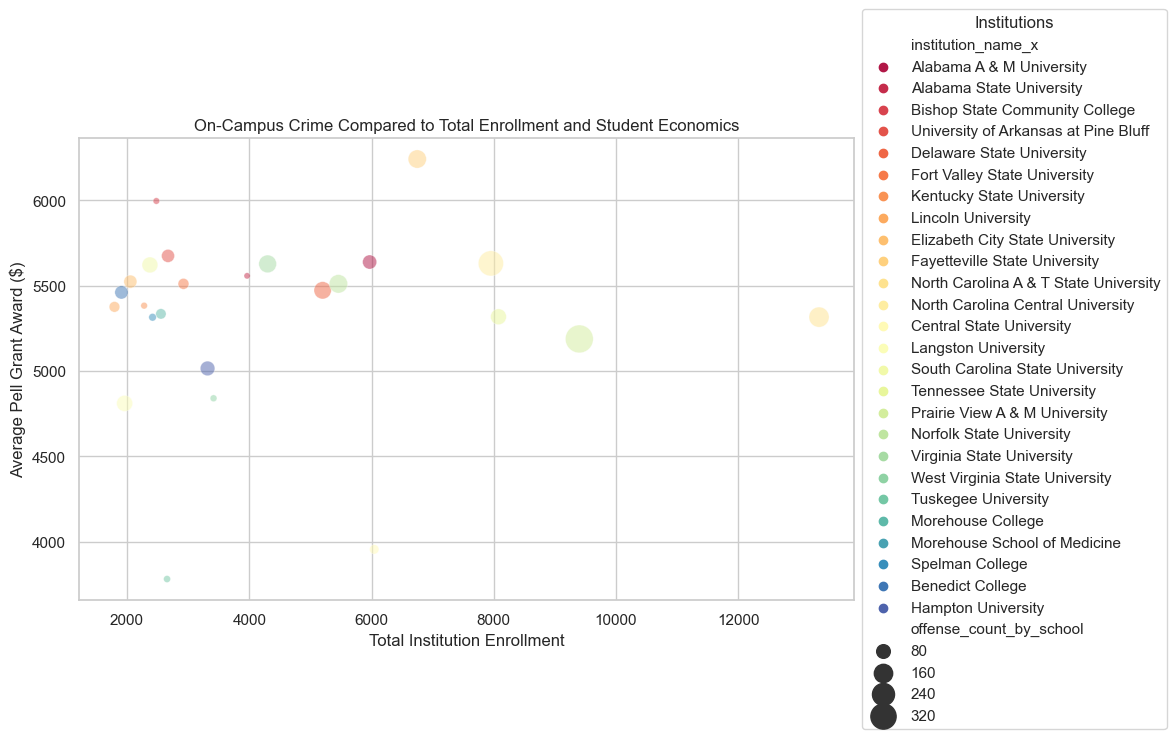

In [56]:
plt.figure(figsize=(10, 6))
x = crimes_enrollment_aid3.iloc[:, 11] 
y = crimes_enrollment_aid3.iloc[:, 12] 
offense_count = crimes_enrollment_aid3.iloc[:, 10]
labels = crimes_enrollment_aid3.iloc[:, 1]

sns.set(style='whitegrid')
#sns.set_palette("muted")

sns.scatterplot(x=x, y=y, size=offense_count, hue=labels,sizes=(20, 400), alpha=0.5, palette= 'Spectral')


plt.legend(loc='center left', bbox_to_anchor=(1, 0.5),title='Institutions')
plt.xlabel('Total Institution Enrollment')
plt.ylabel('Average Pell Grant Award ($)')
plt.title('On-Campus Crime Compared to Total Enrollment and Student Economics')
plt.savefig('../maps/scatter_crime.png',bbox_inches='tight',dpi=300)
plt.show()

In [57]:
crimes_enrollment_aid3.iloc[:,10].sum()

2462